<a href="https://colab.research.google.com/github/ashikshafi08/AICrowd_Competition_Files/blob/main/Fastai/Rover_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Tue Mar 30 02:53:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !pip install fastai --upgrade

In [ ]:
# Downloading the data and putting them inside a folder
!pip install aicrowd-cli 
# API_KEY = ''
!aicrowd login --api-key $API_KEY
# Downloading the datasets
!aicrowd dataset download --challenge rover-classification -j 3

In [ ]:
# Creating folders
!rm -rf data
!mkdir data

!unzip train.zip  -d data/train
!unzip val.zip -d data/val
!unzip test.zip  -d data/test

!mv train.csv data/train.csv
!mv val.csv data/val.csv
!mv sample_submission.csv data/sample_submission.csv

In [1]:
# Importing the packages we need 
from fastai import * 
from fastai.vision.all import * 
import fastai 
fastai.__version__

'2.2.7'

In [2]:
# Setting the path 
train_data = Path('data/train/')
val_data = Path('data/val/')
test_data = Path('data/test/')

In [3]:
# Loading in the train and val dataframe for labels 
import pandas as pd 
import numpy as np 
df_train = pd.read_csv('data/train.csv')
df_valid = pd.read_csv('data/val.csv')

# Checking the head 
df_train.head() 

,ImageID,label
0,0,curiosity
1,1,curiosity
2,2,curiosity
3,3,perseverance
4,4,curiosity


In [4]:
# How many images in both train and val? 
df_train.shape , df_valid.shape

((40000, 2), (4000, 2))

In [5]:
# How does val df looks like? 
df_valid.head()

,ImageID,label
0,0,perseverance
1,1,perseverance
2,2,curiosity
3,3,perseverance
4,4,perseverance


In [6]:
# Adding .jpg extension at every end of Image ID 
def append_ext(fn):
    return f'{fn}.jpg'

# Now applying them 
df_train['ImageID'] = df_train['ImageID'].apply(append_ext)
df_valid['ImageID'] = df_valid['ImageID'].apply(append_ext)

In [7]:
# What changes does it make ? 
df_train.head()

,ImageID,label
0,0.jpg,curiosity
1,1.jpg,curiosity
2,2.jpg,curiosity
3,3.jpg,perseverance
4,4.jpg,curiosity


In [8]:
# Getting the filenames 
train_fns = get_image_files(train_data)
val_fns = get_image_files(val_data)
test_fns = get_image_files(test_data)

In [9]:
train_fns

(#40000) [Path('data/train/13794.jpg'),Path('data/train/1058.jpg'),Path('data/train/37500.jpg'),Path('data/train/8855.jpg'),Path('data/train/10105.jpg'),Path('data/train/23535.jpg'),Path('data/train/25702.jpg'),Path('data/train/23006.jpg'),Path('data/train/2752.jpg'),Path('data/train/6572.jpg')...]

In [10]:
# Transforms 
item_tfms = RandomResizedCrop(460 , min_scale=0.75)
batch_tfms = [*aug_transforms(size = 224 , max_warp= 0 , max_zoom= 0.8) , Normalize.from_stats(*imagenet_stats)]

In [11]:
# Building a DataBlock 
rover_block = DataBlock(blocks=(ImageBlock , CategoryBlock) ,
                        get_x = ColReader(0 , pref = f'{train_data}/') ,
                        splitter = RandomSplitter(), 
                        get_y = ColReader(1), 
                        item_tfms = item_tfms ,
                        batch_tfms = batch_tfms)

# Summary of our DataBlock
rover_block.summary(df_train)

Setting-up type transforms pipelines
0          0.jpg     curiosity
1          1.jpg     curiosity
2          2.jpg     curiosity
3          3.jpg  perseverance
4          4.jpg     curiosity
...          ...           ...
39995  39995.jpg  perseverance
39996  39996.jpg     curiosity
39997  39997.jpg     curiosity
39998  39998.jpg     curiosity
39999  39999.jpg     curiosity

[40000 rows x 2 columns]
Found 40000 items
2 datasets of sizes 32000,8000
Setting up Pipeline: ColReader -- {'cols': 0, 'pref': 'data/train/', 'suff': '', 'label_delim': None} -> PILBase.create
Setting up Pipeline: ColReader -- {'cols': 1, 'pref': '', 'suff': '', 'label_delim': None} -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: ColReader -- {'cols': 0, 'pref': 'data/train/', 'suff': '', 'label_delim': None} -> PILBase.create
    starting from
      ImageID     7267.jpg
label      curiosity
Name: 7267, dtype: object
    applying ColReader -- {'cols': 0, 'pref': 'd

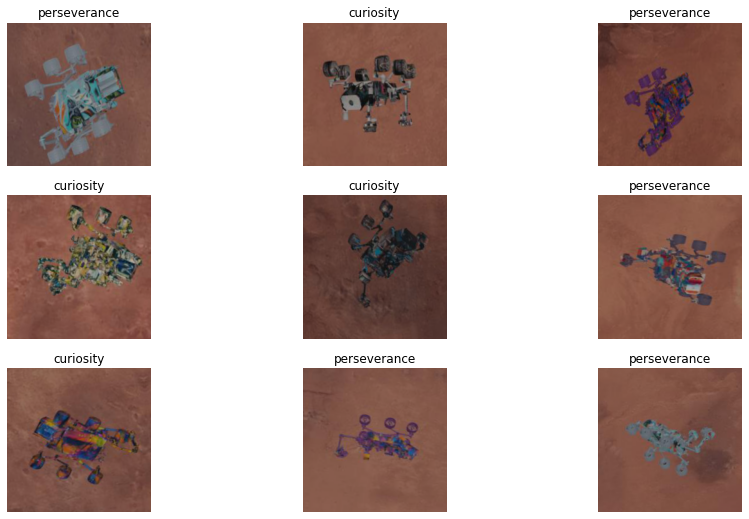

In [12]:
# Putting into a dataloader 
train_dls = rover_block.dataloaders(df_train , batch_size= 32)
train_dls.show_batch(figsize = (15 , 9))

In [13]:
train_dls.vocab

['curiosity', 'perseverance']

In [14]:
# F1 score metric 
f1_score = F1Score(average='micro')

In [15]:
# Creating a learner 
learn = cnn_learner(train_dls , resnet18 , metrics = [error_rate , accuracy  , f1_score] )

In [16]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,time
0,0.205704,0.111628,0.042625,0.957375,0.957375,03:48


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,time
0,0.045645,0.009739,0.003125,0.996875,0.996875,03:51
1,0.023218,0.003384,0.000625,0.999375,0.999375,03:52


epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,time
0,0.045645,0.009739,0.003125,0.996875,0.996875,03:51
1,0.023218,0.003384,0.000625,0.999375,0.999375,03:52
2,0.016551,0.001264,0.000250,0.999750,0.999750,03:51
3,0.005046,0.000292,0.000000,1.000000,1.000000,03:54
4,0.003841,0.000376,0.000125,0.999875,0.999875,03:53


In [18]:
# Load test images 
test_dls = train_dls.test_dl(test_fns)
test_dls

In [ ]:
# Convert categorical values into label names
class_to_label_mapping = {v: k for v, k in enumerate(train_dls.vocab)}
print(class_to_label_mapping)

test_img_ids = [re.sub(r"\D", "", str(img_name)) for img_name in test_fns]
test_img_ids

In [ ]:
_,_,results = learn.get_preds(dl = test_dls, with_decoded = True)

results = [class_to_label_mapping[i] for i in results.numpy()]
results

In [21]:
submission = pd.DataFrame({"ImageID":test_img_ids, "label":results})
submission

,ImageID,label
0,1058,curiosity
1,8855,perseverance
2,2752,perseverance
3,6572,perseverance
4,6609,perseverance
...,...,...
9995,8416,perseverance
9996,1207,perseverance
9997,2097,perseverance
9998,558,perseverance
